In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Duplicate key in file '/Users/pin-jutien/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
df = pd.read_csv("train.csv")
target = "TARGET(PRICE_IN_LACS)"


Column	| Description
------|------
POSTED_BY |	Category marking who has listed the property
UNDER_CONSTRUCTION |	Under Construction or Not
RERA	| Rera approved or Not
BHK_NO	| Number of Rooms
BHKORRK	| Type of property
SQUARE_FT | Total area of the house in square feet
READYTOMOVE	| Category marking Ready to move or Not
RESALE	| Category marking Resale or not
ADDRESS	| Address of the property
LONGITUDE |	Longitude of the property
LATITUDE  |	Latitude of the property


In [3]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [4]:
df.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


<AxesSubplot:>

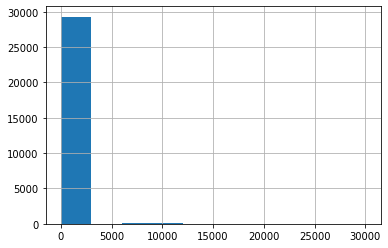

In [5]:
# heavy tail distribution in the target.
# note: use quantile transformation to 
df[target].hist(bins=10)

In [6]:
df.shape

(29451, 12)

In [7]:
df.columns.tolist()

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'BHK_OR_RK',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'ADDRESS',
 'LONGITUDE',
 'LATITUDE',
 'TARGET(PRICE_IN_LACS)']

In [8]:
df.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [9]:
numerical_features = ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']
categorical_features = ['POSTED_BY','UNDER_CONSTRUCTION', 'RERA', 'BHK_OR_RK', 
                        'READY_TO_MOVE', 'RESALE', 'ADDRESS']
len(numerical_features), len(categorical_features)

(4, 7)

In [10]:
df[numerical_features].describe()

,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE
count,29451.000000,2.945100e+04,29451.000000,29451.000000
mean,2.392279,1.980217e+04,21.300255,76.837695
std,0.879091,1.901335e+06,6.205306,10.557747
min,1.000000,3.000000e+00,-37.713008,-121.761248
25%,2.000000,9.000211e+02,18.452663,73.798100
50%,2.000000,1.175057e+03,20.750000,77.324137
75%,3.000000,1.550688e+03,26.900926,77.828740
max,20.000000,2.545455e+08,59.912884,152.962676


In [11]:
df[categorical_features].describe()

,UNDER_CONSTRUCTION,RERA,READY_TO_MOVE,RESALE
count,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,0.820244,0.929578
std,0.383991,0.465675,0.383991,0.255861
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [26]:
df[numerical_features + [target]].corr()[target]

BHK_NO.                  0.112283
SQUARE_FT                0.402685
LONGITUDE               -0.031112
LATITUDE                -0.017254
TARGET(PRICE_IN_LACS)    1.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

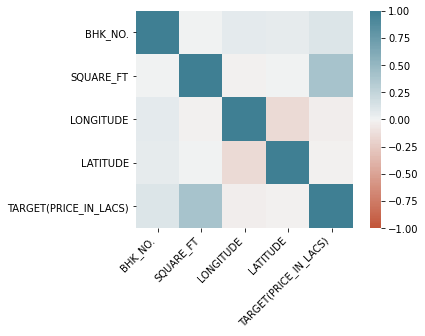

In [15]:

ax = sns.heatmap(
    df[numerical_features + [target]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
